# Introduction to the problem and basic approach

## Introduction (Data + Basic Imports)

In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Import as Dataframe
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [4]:
df.tail()

,value
date,
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677
2008-05-01,22.912510
2008-06-01,19.431740


In [3]:
len(df)

204

<AxesSubplot:xlabel='date'>

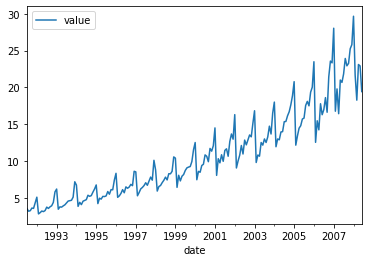

In [2]:
df.plot()

In [7]:
df.shape[0] * 0.6

122.39999999999999

In [8]:
df.iloc[:122]

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2001-04-01,9.753358
2001-05-01,10.850382
2001-06-01,9.961719


# Classical ML Approach

## Train / Test split

In [9]:
# let's keep the last 40% values out for test purposes
train_size = 0.6
index = round(train_size*df.shape[0])
df_train = df.iloc[:index]
df_test = df.iloc[index:]

## Baseline model

- 1 feature only: X[t] = y[t-1]
- Predict the previous value!

In [10]:
y_pred = df_test.shift(1)
y_pred

,value
date,
2001-09-01,NaN
2001-10-01,10.647060
2001-11-01,12.652134
2001-12-01,13.674466
2002-01-01,12.965735
...,...
2008-02-01,29.665356
2008-03-01,21.654285
2008-04-01,18.264945


In [11]:
from sklearn.metrics import r2_score

y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]
print(f"R2:{r2_score(y_true, y_pred)}")

R2:0.5069517261286796


## Linear Model

Let's build our dataset X with 12 auto-regressive features

In [12]:
df2 = df.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['value'].shift(i)
    df2_test[f't - {i}'] = df_test['value'].shift(i)

df2_train.dropna(inplace=True)    
df2_test.dropna(inplace=True)    
df2_train.head()

,value,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
date,,,,,,,,,,,,,
1992-07-01,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891,3.526591
1992-08-01,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891
1992-09-01,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221
1992-10-01,3.924490,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003
1992-11-01,4.386531,3.924490,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869


In [13]:
# Feature and target definition
X2_train = df2_train.drop(columns = ['value'])
y2_train = df2_train['value']

X2_test = df2_test.drop(columns = ['value'])
y2_test = df2_test['value']

In [14]:
# Predict and measure R2
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))

R2:  0.8580874548863759


In [15]:
model.coef_

array([-0.01643347,  0.02982289,  0.00478325,  0.00232188,  0.00907542,
       -0.00549023,  0.00572397, -0.00734352,  0.00429859,  0.04992893,
       -0.0186112 ,  1.05015253])

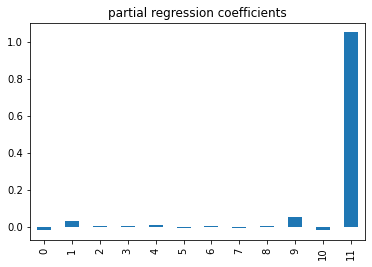

In [16]:
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

# Exploratory visualization of a Time Series

## Decomposing

When thinking about time series, there are 3 things we can look out for:
- **trend** (is the value increasing/decreasing over time?)
- **seasonality** (is the value repeating a pattern over time?)
- **residuals** (what is the thing that time cannot explain in our data?)

With the right combination of those 3, we can get our real value by either adding them up (additive approach) or by multiplying them (multiplicative approach)

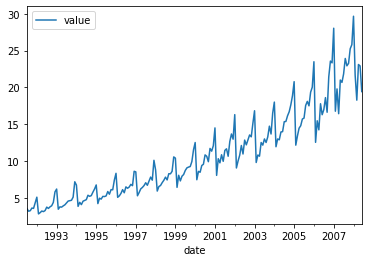

In [21]:
df.plot();

### Additive Approach

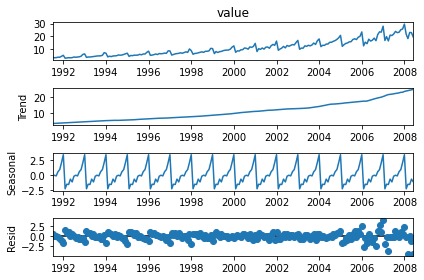

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's get our values by finding a trend, season and residual that and suming them (value = trend + season + residual)
results_add = seasonal_decompose(df.value, model='aditive', extrapolate_trend='freq')
results_add.plot();

### Multiplicative Approach

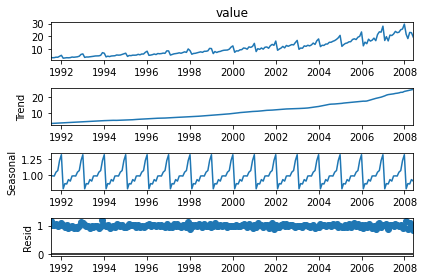

In [23]:
# Let's get our values by finding a trend, season and residual that and multiplying them (value = trend * season * residual)
results_mul = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend='freq')
results_mul.plot();

In [24]:
print(df.head(1).value)
print(results_add.trend[0] + results_add.seasonal[0] + results_add.resid[0])
print(results_mul.trend[0] * results_mul.seasonal[0] * results_mul.resid[0])

date
1991-07-01    3.526591
Name: value, dtype: float64
3.526591
3.526591


Besides the scale, there doesn't seem to be much of a difference between each strategy...

... but there is. Let's take a closer look at the residuals computed for each approach

### Stationarity

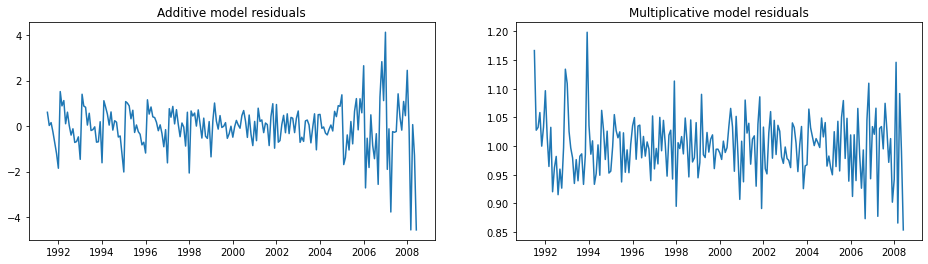

In [25]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(results_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(results_mul.resid); ax2.set_title("Multiplicative model residuals");

<details>
    <summary>Which residual is better? (click here to find the answer)</summary>

When looking through both graphs, we can observe that the Additive approach has some pattern in its residuals. Whenever we see a pattern (could be a trend, a seasonality or both), we say that the data is **non-stationary**, meaning it depends on time to get its values.

Counter intuitively, however, when working with Time Series **we want to get rid of the time factor**! That's because time itself cannot be used as a feature, and therefore will just make our lives harder when trying to predict new values.

In other words, we'll try to find the patterns in our data without taking into consideration time itself. Pretty crazy huh?

In conclusion, the multiplicative approach is actually better, since it doesn't show a pattern over time (aka it's **stationary**)
</details>

### ADF Test

Another way to check for stationarity (instead of just looking at the data) is through a method called **Augmented Dickey Fuller - ADF Tests**.

It makes an hypothesis testing on the data, where \$h_0$ is the hypothesis of it being, in fact, non-stationary. If the result is below 0.05 (our p-value), it means that the probability of the hypothesis being true is very low, and therefore we can assume the opposite (the data is stationary).

In [26]:
from statsmodels.tsa.stattools import adfuller

# calculate the adf for the original values. the p-value should be high!
adfuller(df.value)[1]

1.0

In [27]:
# now calculate the adf for both the additive and multiplicative residuals. The lowest p-value will be the best one to use later
print('Additive approach: ', adfuller(results_add.resid)[1])
print('Multiplicative approach: ', adfuller(results_mul.resid)[1])

Additive approach:  4.896059242320234e-07
Multiplicative approach:  2.1545183905422287e-13


Just to keep track of things, after choosing one of the approaches, we might store the given values into the DataFrame for later use

In [28]:
df['trend'] = results_mul.trend
df['season'] = results_mul.seasonal
df['resid'] = results_mul.resid
df.head()

,value,trend,season,resid
date,,,,
1991-07-01,3.526591,3.060085,0.987845,1.166629
1991-08-01,3.180891,3.124765,0.990481,1.027745
1991-09-01,3.252221,3.189445,0.987476,1.032615
1991-10-01,3.611003,3.254125,1.048329,1.058513
1991-11-01,3.565869,3.318805,1.074527,0.999923


### Differencing

One problem that we still have is that our original value (which is the one we'll try to predict) is non-stationary. We need to make it stationary (to train a model), but in a way that we'll be able to revert later (as to get the real values after we make our predictions). This is what differencing does by simply subtracting the previous value from the actual one. Here's a quick example:

<AxesSubplot:xlabel='date'>

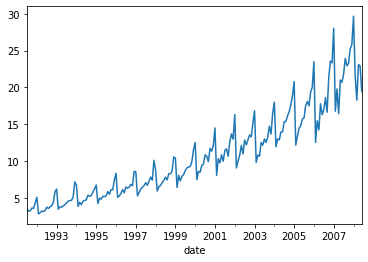

In [29]:
df.value.plot()

In [30]:
non_differenced_data = pd.Series([7, 4, 4, 6, 8, 6])
differenced_1 = non_differenced_data.diff()
differenced_1.dropna(inplace=True)
print(differenced_1)

1   -3.0
2    0.0
3    2.0
4    2.0
5   -2.0
dtype: float64


In our case, all we need to do is to `diff` our values until they are stationary

<AxesSubplot:xlabel='date'>

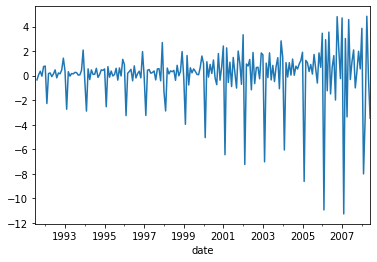

In [31]:
diffed_values = df.value.diff()
diffed_values.plot()

It does look like we still have the seasonality in the data, though...

Oh well, might as well diff it again!

<AxesSubplot:xlabel='date'>

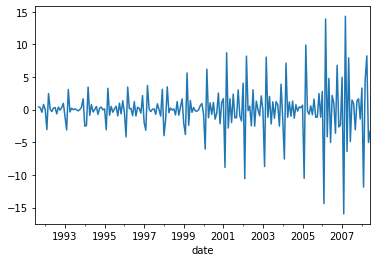

In [32]:
diffed_values2 = diffed_values.diff()
diffed_values2.plot()

We could try as many times as we'd like, but in this case, the seasonality won't vanish. The trick here will be to first get the seasonality out of our values and only them "diffing" them.

<AxesSubplot:xlabel='date'>

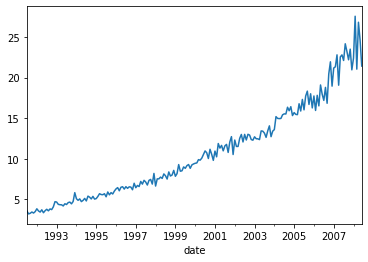

In [33]:
# desason the values
df['deseasonalized'] = df.value.values/df.season
df['deseasonalized'].plot()

Here we see another problem: the values are growing exponentially. We need to convert that into a linear growth.

<AxesSubplot:xlabel='date'>

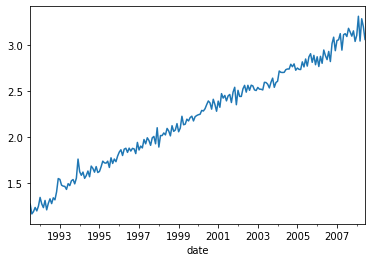

In [34]:
# convert the desasonalized values (how to convert an exponential curve into a linear one?)
df['linearized'] = np.log(df.deseasonalized)
df['linearized'].plot()

<AxesSubplot:xlabel='date'>

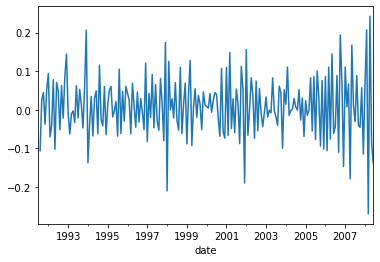

In [35]:
df['diffed_one'] = df.linearized.diff()
df['diffed_one'].plot()

In [36]:
adfuller(df.diffed_one.dropna())[1]

8.541361073452114e-10

<AxesSubplot:xlabel='date'>

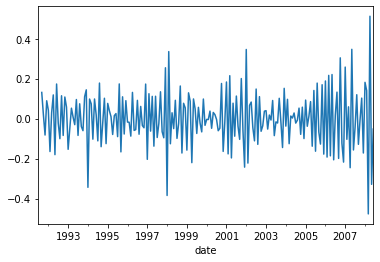

In [37]:
df['diffed_two'] = df.diffed_one.diff()
df['diffed_two'].plot()

In [38]:
adfuller(df.diffed_two.dropna())[1]

1.2877604699007502e-12

No need to over-differenciate

Usually, 1-diff is enough! If not, you might have exponential behavior and might want to use a log transformation instead! Alternatively, we can de-trend and work with the detrended series without differencing.

Finally, we have a stationary version of our values and we can move on.

In [39]:
df

,value,trend,season,resid,deseasonalized,linearized,diffed_one,diffed_two
date,,,,,,,,
1991-07-01,3.526591,3.060085,0.987845,1.166629,3.569985,1.272561,NaN,NaN
1991-08-01,3.180891,3.124765,0.990481,1.027745,3.211461,1.166726,-0.105835,NaN
1991-09-01,3.252221,3.189445,0.987476,1.032615,3.293470,1.191942,0.025216,0.131051
1991-10-01,3.611003,3.254125,1.048329,1.058513,3.444533,1.236788,0.044847,0.019631
1991-11-01,3.565869,3.318805,1.074527,0.999923,3.318548,1.199527,-0.037261,-0.082108
...,...,...,...,...,...,...,...,...
2008-02-01,21.654285,24.037399,0.785976,1.146165,27.550814,3.316032,0.207058,0.140269
2008-03-01,18.264945,24.298458,0.868249,0.865756,21.036534,3.046261,-0.269771,-0.476830
2008-04-01,23.107677,24.559516,0.861883,1.091662,26.810702,3.288801,0.242540,0.512312


## Autocorrelation (ACF) and Partial Autocorrelation (AR / PACF)

### Autocorrelation - Direct and Indirect impact of previous values against the present one

The autocorrelation statistic measures how much does a value that is $n$ moments (hours, days, months, years, etc.) impacts the present value, both directly and indirectly.
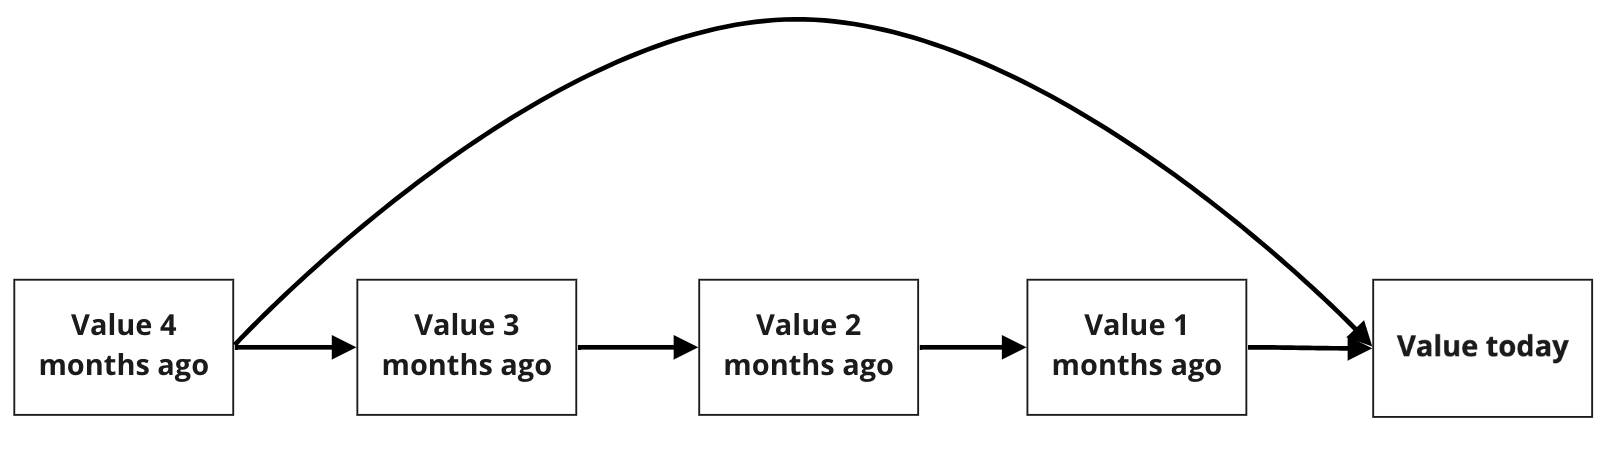

In [40]:
df.head(10)[['value']]

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
1991-12-01,4.306371
1992-01-01,5.088335
1992-02-01,2.814520
1992-03-01,2.985811


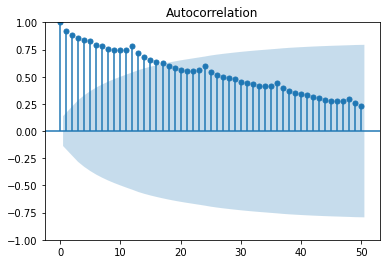

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

# let's see the acf for every value from 1 up to 50 "lags" before the actual one
plot_acf(df.value, lags=50)
plt.show()

The graph shows that the actual value (lag=0) has 100% correlation with... the actual value (obviously!)

But it also shows that the value immediately before the actual one also has a high correlation with the actual value. And as we look further and further away, each correlation gets weaker and weaker, with some peaks every 12 values.

<details>
    <summary>Wait a minute, why the peaks? 🤔 (click here after taking a guess)</summary>
    
Seasonality. The pattern repeats itself every 12 months, aka yearly. So the correlation between this year's January will be stronger with last year's January as well (not as much as last December, though) 😉
</details>

### Partial Autocorrelation - Direct impact only

It might get hard for us to actually get a sense on how much does a past value actually impacts the present one, since we have the Domino effect which makes it also impacts indirectly. So, how can we actually know how important are past values to predict the right one?

Answer: Partial Autocorrelation (ACF), also known as Auto Regression (AR). This strategy can be seen as a linear regression of previous months in order to get the actual one, where the coefficients are the direct correlations each previous month has to the actual.

<center>
$
\large Y_t = \alpha + \color{red}{\beta_1} Y_{t-1} + \color{red}{\beta_2} Y_{t-2} + \dots + \color{red}{\beta_p} Y_{t-p} + \epsilon_t
$
</center>

/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


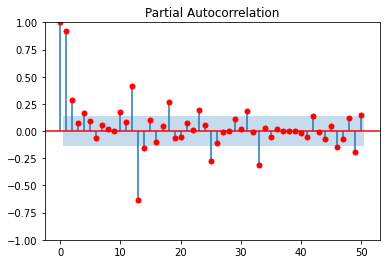

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.value, lags=50, c='r')
plt.show()

The values shown in the graph above are the same as the ACF ones: they are correlations. However, AR removes the indirect correlation that past values might have between each other. So now, we can see that the month before the actual has a great correlation, but looking at two months before won't give us as much information. Looking 12 months behind, as expected, will also give us a high correlation by itself because of the seasonality

## Moving Average (MA)

One last info that we need to look at before running some Time Series models is the Moving Average. In this approach, we look at the average of a certain amount of values prior to the actual one and check the absolute difference between that average and the actual value, like illustrated below
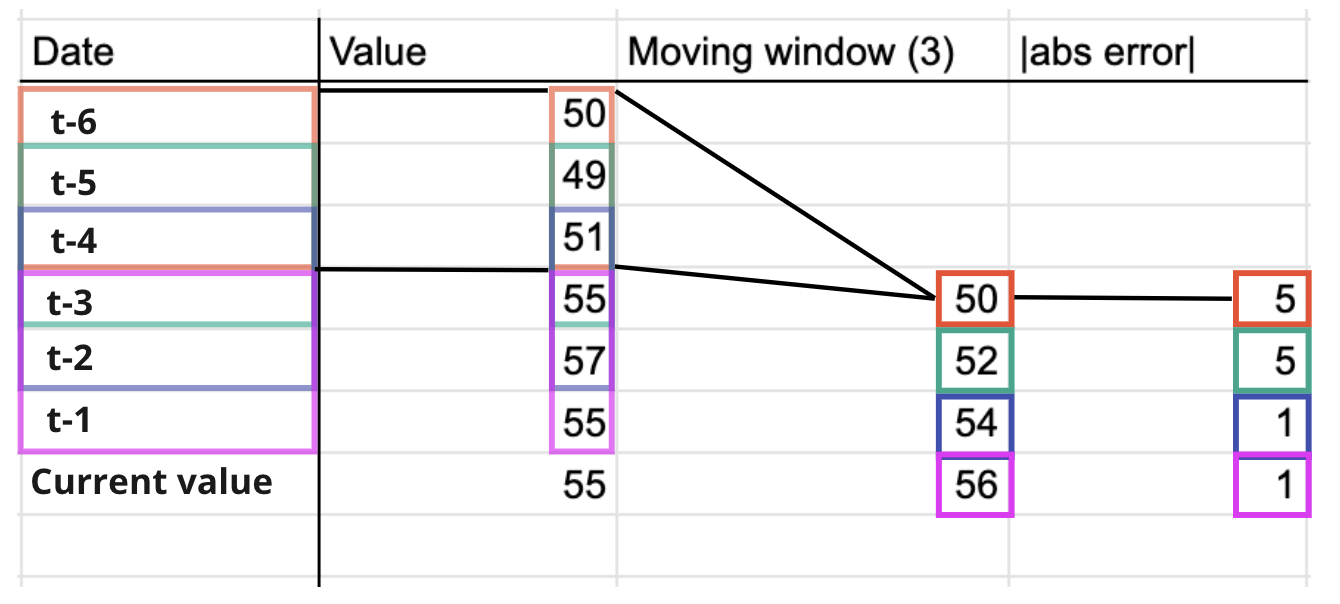

Although we could try to make this computation by hand, we won't have to. So no code is needed here 😁

# ARIMA - Auto Regressive Integrated Moving Average

To recap things, so far we've seen how:
- a value in a Time Series can be caculated by a combination of trend, seasonality and residuals
- we need to difference our data in order to make it stationary (and we can diff it as many times as needed)
- Auto Regression (AR) shows how much does values prior to the actual one **directly** impact it
- Moving Averages (MA) shows how far is the actual value to an average of some values prior to it

<details>
    <summary>Can you explain what we'd be trying to predict if we had a model with each approach? 🤔 (click here for an answer)</summary>

- A Differencing model would try to predict the actual value based on a pattern in the residuals between the actual value and it's past value
- An AR model would try to predict the actual value based on the direct impact (correlation) previous months have
- A MA model would try to predict the actual value based on the average value of $n$ values before it
</details>

## Model Parameters

By combining these informations, clever people got to an interesting model called ARIMA. In it, we need to decide three parameters:
- The amount of months prior the actual one to auto regress (which we'll call $p$)
- The amount of times we'll diff our values to make them stationary (which we'll call $i$)
- The amount of months to get the average and test against the actual one (which we'll call $q$)

It's not hard to get a good guess! Here's an example:

/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


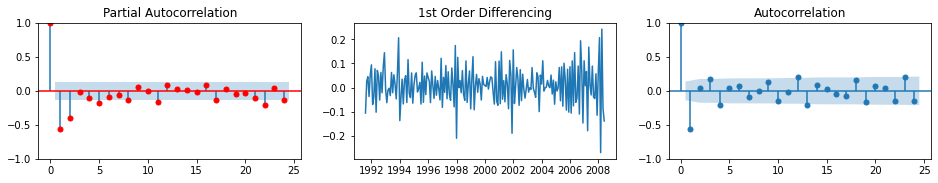

In [43]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
plot_pacf(df['diffed_one'].dropna(), ax=axes[0], c='r');
axes[1].plot(df['diffed_one']); axes[1].set_title('1st Order Differencing')
plot_acf(df['diffed_one'].dropna(), ax=axes[2]);

- With PACF, you'll be able to find $p$ by looking at how many dots you have **before the first one reaches the confidence area**
- With 1st Order Differencing, you'll be able to check if your data is stationary. If not, diff it again (**but not too much**)
- With ACF, you'll be able to find $q$ by looking at how many dots you have **before the first one reaches the confidence area**

In our case, $p = 2, i = 1, q = 1$

In [44]:
df.head(3)

,value,trend,season,resid,deseasonalized,linearized,diffed_one,diffed_two
date,,,,,,,,
1991-07-01,3.526591,3.060085,0.987845,1.166629,3.569985,1.272561,NaN,NaN
1991-08-01,3.180891,3.124765,0.990481,1.027745,3.211461,1.166726,-0.105835,NaN
1991-09-01,3.252221,3.189445,0.987476,1.032615,3.293470,1.191942,0.025216,0.131051


In [45]:
#from statsmodels.tsa.arima_model import ARIMA #statsmodels 0.11
from statsmodels.tsa.arima.model import ARIMA #statsmodels 0.12

arima = ARIMA(df['linearized'], order=(2,1,1))
arima = arima.fit()
arima.summary()

/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             linearized   No. Observations:                  204
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 278.694
Date:                Thu, 12 May 2022   AIC                           -549.387
Time:                        11:18:17   BIC                           -536.135
Sample:                    07-01-1991   HQIC                          -544.026
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9741      0.171     -5.698      0.000      -1.309      -0.639
ar.L2         -0.4877      0.098     -4.988      0.000      -0.679      -0.296
ma.L1          0.2509      0.186      1.351      0.177      -0.113       0.615
sigma2         0.0037      0.000     12.871      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):                22.28
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.51
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Grid searching $p$, $i$ and $q$

In [46]:
#!pip install --quiet pmdarima

In [47]:
import pmdarima as pm
smodel = pm.auto_arima(df['linearized'],
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-576.198, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-455.474, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-531.974, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-575.110, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-454.894, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-574.263, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-574.208, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-575.758, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-572.564, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-575.584, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-539.184, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.433 seconds


Although (1,1,1) holds the best score, (0,1,1) gets pretty close and takes less time (trade-off).

## Predicting new values

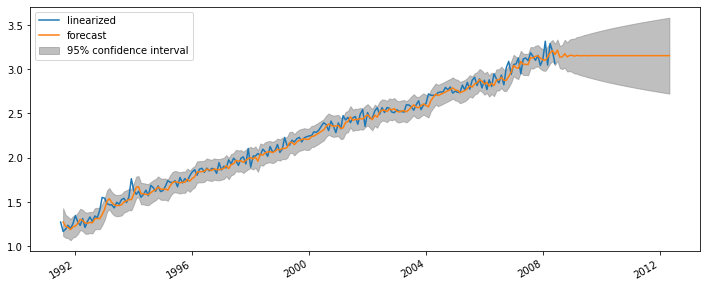

In [48]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df['linearized'], label='linearized')
plot_predict(arima, start=1, end=250, ax=axs);

In [52]:
# Create a correct Training/Test split to predict the last 50 points
train = df['linearized'][0:150]
test = df['linearized'][150:]

# Build Model
arima = ARIMA(train, order=(2, 1, 0), trend='t')  
arima = arima.fit()

# Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [55]:
# We define here a "Plot forecast vs. real", which also shows historical train set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='blue')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

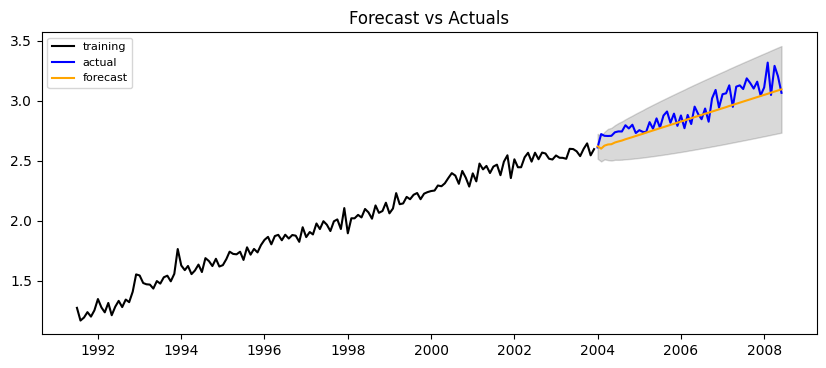

In [56]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

### Don't forget to re-scale your values!

Remember that we deseasonalized and log'd our actual values? After predicting a forecast, we can revert the transformation by exponentiating the results and multiplying them back with the seasonality.

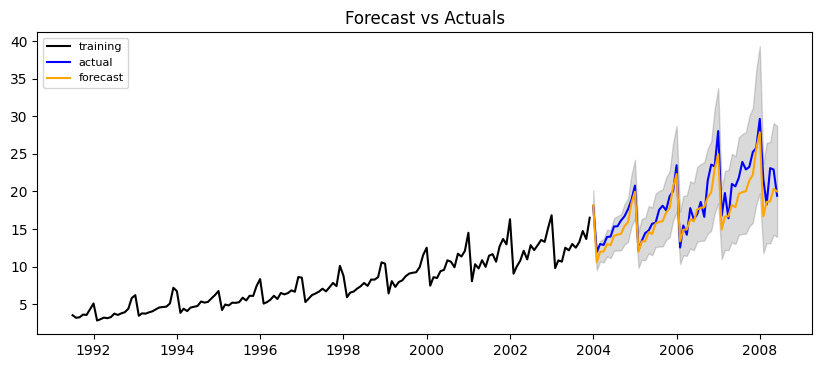

In [57]:
# get back the actual values
train_recons = np.exp(train) * df.season[0:150]
test_recons = np.exp(test) * df.season[150:]

# convert the predict values the same way
forecast_recons = np.exp(forecast) * df.season[150:]
lower_recons = np.exp(confidence_int)[:,0] * df.season[150:]
upper_recons = np.exp(confidence_int)[:,1] * df.season[150:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

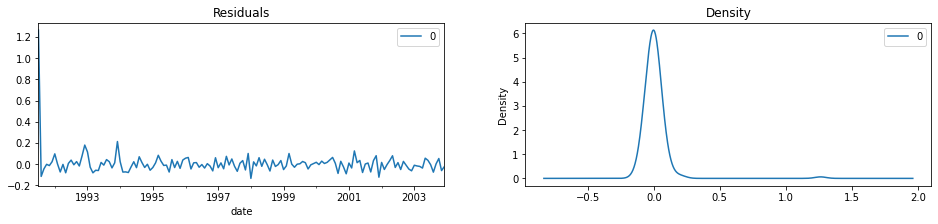

In [58]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

# SARIMA - Seasonal Auto Regressive Integrated Moving Average

Removes the need to deseasonalize our data

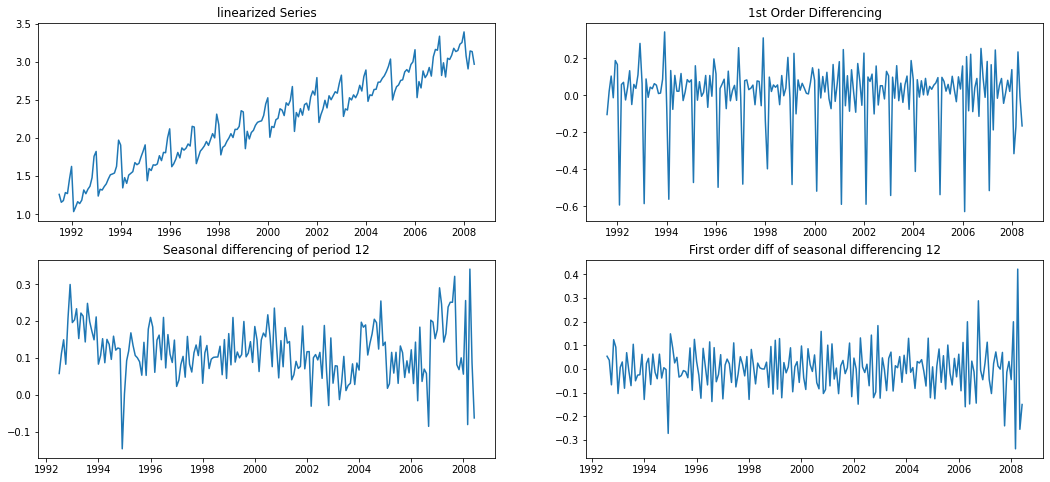

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df['log'] = np.log(df.value)

# linearized series
axs[0,0].plot(df.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [60]:
# Create a correct Training/Test split to predict the last 50 points
train = df.log[0:150]
test = df.log[150:]

In [61]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-83.662, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-85.171, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-190.471, Time=0.49 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-315.673, Time=1.38 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-332.174, Time=3.80 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-326.583, Time=4.04 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-362.831, Time=5.14 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-360.691, Time=2.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-366.713

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train, order=(0, 1, 1), seasonal_order=(1, 0, 2, 12))
sarima = sarima.fit(maxiter=75)

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/matheus/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.99736D-01    |proj g|=  4.84779D+00

At iterate    5    f= -1.29862D+00    |proj g|=  1.75590D+00

At iterate   10    f= -1.30853D+00    |proj g|=  1.53663D+00

At iterate   15    f= -1.34122D+00    |proj g|=  1.12621D-01

At iterate   20    f= -1.34676D+00    |proj g|=  8.26187D-01

At iterate   25    f= -1.34858D+00    |proj g|=  2.19812D-01

At iterate   30    f= -1.35998D+00    |proj g|=  3.54951D-01

At iterate   35    f= -1.38605D+00    |proj g|=  1.41374D-01

At iterate   40    f= -1.40126D+00    |proj g|=  4.87863D-01

At iterate   45    f= -1.40286D+00    |proj g|=  5.84860D-02

At iterate   50    f= -1.40290D+00    |proj g|=  2.10333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

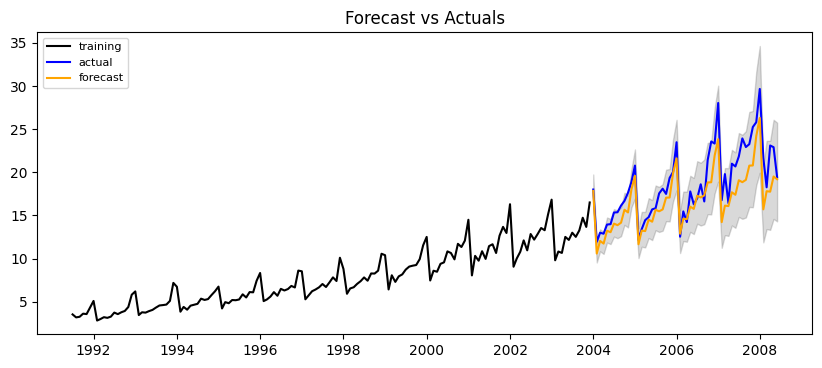

In [63]:
# Reconstruct by taking exponential
forecast_recons = pd.Series(np.exp(forecast), index=test.index)
lower_recons = np.exp(confidence_int['lower log']).values
upper_recons = np.exp(confidence_int['upper log']).values

plot_forecast(forecast_recons, np.exp(train), np.exp(test), upper = upper_recons, lower=lower_recons)

In [64]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                     log   No. Observations:                  150
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 210.435
Date:                                 Thu, 12 May 2022   AIC                           -410.871
Time:                                         11:46:43   BIC                           -395.851
Sample:                                     07-01-1991   HQIC                          -404.768
                                          - 12-01-2003                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7986      0.061    -13.023      0.000      -0.919      -0.678
ar.S.L12       0.9975      0.003    303.850      0.000       0.991       1.004
ma.S.L12      -0.4342      0.088     -4.937      0.000      -0.607      -0.262
ma.S.L24      -0.3446      0.118     -2.909      0.004      -0.577      -0.112
sigma2         0.0027      0.000      9.069      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 8.30
Prob(Q):                              0.70   Prob(JB):                         0.02
Heteroskedasticity (H):               0.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""